In [1]:
import cirq
import qsimcirq
import numpy as np
import qiskit
import qiskit_ibm_runtime
from qiskit_aer import AerSimulator
import stimcirq
import matplotlib.pyplot as plt

from qiskit.visualization import plot_histogram
from encoded.dj import dj, dj_repetition, dj_steane
from encoded.LST import int_to_binary

## Computer parameters

In [2]:
# Computer and qubits to use.
# Option 1: Use saved noise characteristics.
computer = qiskit_ibm_runtime.fake_provider.FakeKyiv()
#computer = AerSimulator()  # Noiseless simulator - use this for a sanity check to see all computed expectation
layout = {
    1 : [63, 64],
    3 : [65, 66, 67, 73, 84, 85],
    5 : [64, 65, 66, 67, 72,81, 82, 83, 84, 85],
    7 : [61, 62, 63, 64, 65, 66, 67, 72, 73, 81, 82, 83, 84, 85],
    #7 : [117,122,123, 124, 125, 126, 127,136,137,143,144,145,146,147]
}

## Oracle definition

In [3]:
total_qubits = 2
# Random case
# oracleType, oracleValue = np.random.randint(2), np.random.randint(2)
# if oracleType == 1:
#     oracleValue = np.random.randint(1, 2**(total_qubits-1))

# Fixed case
oracleType, oracleValue = 1, 2**(total_qubits-1)-1
oracleType,oracleValue

(1, 1)

## Full conectivity

### Analog version

In [13]:
n_shots = 600_000
noise = cirq.depolarize
simulator = stimcirq.StimSampler()
noise_set = [0.1]#np.logspace(-5,-3,10)
infidelity_analog = []
for noise_ratio in noise_set:
    qreg = cirq.LineQubit.range(total_qubits)
    circuit = dj(qreg,oracleType,oracleValue)
    print(circuit)
    circuit.append(cirq.measure(qreg[:total_qubits-1], key="m"))
    circuit = circuit.with_noise(noise(noise_ratio))
    counts = simulator.run(circuit, repetitions=n_shots).histogram(key="m")
    # if oracleType==1:
    infidelity_analog.append(1-counts[int(int_to_binary(total_qubits-1,oracleValue))]/n_shots)
    # else:
    #     infidelity_analog.append(1-counts[int("0"*(total_qubits-1))]/n_shots)

0: ───H───────@───H───
              │
1: ───X───H───X───────


### Repetition code version

In [5]:
from encoded.repetition_code import encoding_repetition, repetition_H, repetition_X, repetition_CNOT


def repetition_H_half(circuit: cirq.Circuit, qubits,n, qi: int):
    """
    logical hadamard gate opf the repetition code without the first row of CNOT. This is not corresponding to the true logical hadamard gate of the repetition code but this can be used for simplifying the circuit depth.

    """
    circuit.append(cirq.H.on(qubits[qi * n]))
    for i in range(n - 1):
        circuit.append(cirq.CNOT.on(qubits[qi * n + i], qubits[qi * n + i + 1]))



def dj_repetition_debug(qreg, n_encoding: int, oracleType: int, oracleValue: int) -> cirq.Circuit:
    """
    Implementation of the Deutsch Jozsa algorithm using the repetition code for encoding a logical qubit. This aims to perform a scaling experiment.
    Args:
        - qregs: set of n_encoding*(k+1) qubits for k logical qubits representing the register for querying the oracle and the last logical qubit is the register for storing the answer of the oracle.
        - n_encoding: the number of qubits in the repetition code
        - oracleType: type of oracle to be used. If oracleType is "0", the oracle is unbalanced otherwise it is balanced
        - oracleValue: value to be returned by the oracle if oracleType is "1"
    Returns:
        - cirq.Circuit: quantum circuit for the Deutsch Jozsa algorithm encoded in the repetition code
    """
    # implementing quantum electro
    circuit_dj = cirq.Circuit()
    k = len(qreg) // n_encoding - 1

    # initialization
    for i in range(k):
        repetition_H_half(circuit_dj, qreg, n_encoding, i)

    for i in range(n_encoding):
        circuit_dj.append(cirq.X.on(qreg[k * n_encoding + i]))
    repetition_H_half(circuit_dj, qreg, n_encoding, k)

    if oracleType == 0:  # If the oracleType is "0", the oracle returns oracleValue for all input.
        if oracleValue == 1:
            for i in range(n_encoding):
                circuit_dj.append(cirq.X.on(qreg[k * n_encoding + i]))
    else:  # Otherwise, it returns the inner product of the input with a (non-zero bitstring)
        for i in range(n_encoding * k):
            if oracleValue & (1 << i):
                repetition_CNOT(circuit_dj, qreg, n_encoding, i, k)

    # finalization
    for i in range(k):
        repetition_H(circuit_dj, qreg, n_encoding, i)

    return circuit_dj


In [5]:
k = 2 
n_encoding = 5

qreg = cirq.LineQubit.range(n_encoding*k)
circuit= dj_repetition(qreg,n_encoding,oracleType,oracleValue)

circuit

┌──┐   ┌──┐   ┌──┐   ┌──┐
0: ───H───@─────@─────────────────────────────────────@───H───@───X───────────────
          │     │                                     │       │
1: ───────X────@┼──────@──────────────────────────@───X───────X───@───X───────────
               ││      │                          │               │
2: ────────────X┼─────@┼──────@───────────────@───X───────────────X───@───X───────
                │     ││      │               │                       │
3: ─────────────┼─────X┼─────@┼─────@─────@───X───────────────────────X───@───X───
                │      │     ││     │     │                               │
4: ─────────────┼──────┼─────X┼─────┼@────X───────────────────────────────X───X───
                │      │      │     ││
5: ───H───@─────X──────┼──────┼─────┼┼────────────────────────────────────────────
          │            │      │     ││
6: ───────X────@───────X──────┼─────┼┼────────────────────────────────────────────
               │              │     ││
7: ────────────X──────@───────X─────┼┼────────────────────────────────────────────
                      │             ││
8: ───────────────────X──────@──────X┼────────────────────────────────────────────
                             │       │
9: ──────────────────────────X───────X────────────────────────────────────────────
              └──┘   └──┘   └──┘   └──┘

In [6]:
oracleType, oracleValue = 1, 2**(total_qubits-1)-1
k = 2 
n_encoding = 3

logical_1_codeword = ["1"*n_encoding*(k-1)]
logical_0_codeword = ["0"*n_encoding*(k-1)]


infidelity_encoded = []
for noise_ratio in noise_set:
    qreg = cirq.LineQubit.range(n_encoding*k)
    circuit= dj_repetition(qreg,n_encoding,oracleType,oracleValue)
    circuit.append(cirq.measure(qreg[:n_encoding*(k-1)], key="m"))
    circuit = circuit.with_noise(noise(noise_ratio))
    counts = simulator.run(circuit, repetitions=n_shots).histogram(key="m")

    counts_logical_1 = 0
    for e in logical_1_codeword:
        counts_logical_1 += counts[int(e,2)]
    counts_logical_0 = 0
    for e in logical_0_codeword:
        counts_logical_0 += counts[int(e,2)]

    # if oracleType==1 and oracleValue ==1:
        infidelity_encoded.append(1-counts_logical_1/(counts_logical_1+counts_logical_0))
    # else:
        # infidelity_encoded.append(1-counts_logical_0/(counts_logical_1+counts_logical_0))


In [9]:
infidelity_analog

[4.499999999996174e-05,
 5.6666666666704835e-05,
 9.00000000000345e-05,
 0.00017333333333335865,
 0.0003083333333333549,
 0.0005199999999999649,
 0.0008700000000000374,
 0.0014166666666666217,
 0.0023900000000000032,
 0.004214999999999969]

In [8]:
infidelity_encoded

[0.00010835355933103141,
 0.0001467075002542506,
 0.00022844108137676233,
 0.00042366379109037844,
 0.0006809340144898757,
 0.0011126016334862543,
 0.0018506062157612746,
 0.0031181805525503092,
 0.005218082838960525,
 0.008604441669791019]

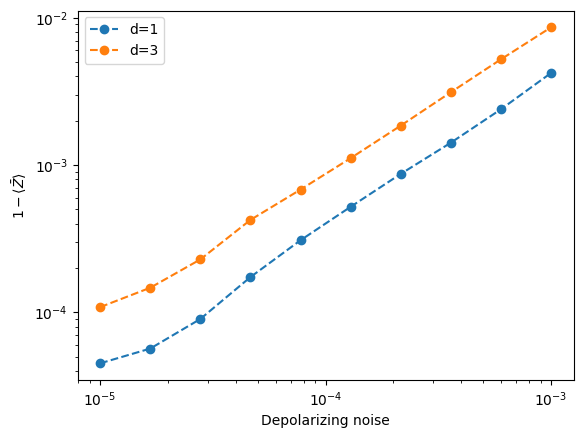

In [10]:
plt.figure()
plt.loglog(noise_set,infidelity_analog,"--o",label = "d=1")
plt.loglog(noise_set,infidelity_encoded,"--o",label = "d=3")


# plt.ylim(1e-4,5e-1)
plt.xlabel("Depolarizing noise")
plt.ylabel(r"$1-\langle \bar{Z} \rangle$")
plt.legend()


## Transpiled

We now transpile the circuit to a FakeIbm computer but use the cirq noise model

In [ ]:
def count_gates(qc: qiskit.QuantumCircuit):
    gate_count = {qubit: 0 for qubit in qc.qubits}
    for gate in qc.data:
        for qubit in gate.qubits:
            gate_count[qubit]+=1
    return gate_count

def remove_idle_qwires(qc: qiskit.QuantumCircuit):
    gate_count = count_gates(qc)
    for qubit,count in gate_count.items():
        if count==0:
            qc.qubits.remove(qubit)
    return qc

## Analog version

In [26]:
import qiskit_aer.noise as noise
n_shots = 500_000
qreg = cirq.LineQubit.range(total_qubits)
circuit = dj(qreg,oracleType,oracleValue)
circuit.append(cirq.measure(qreg[:total_qubits-1], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())
computer = qiskit_ibm_runtime.fake_provider.FakeKyiv()

compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    initial_layout=layout[1],  
    routing_method="sabre",
    optimization_level=0,
)


job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()

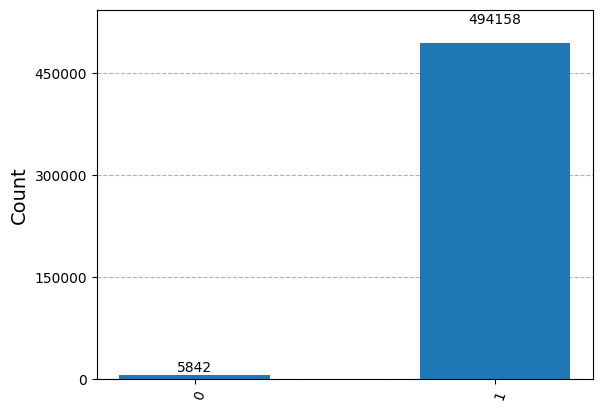

In [27]:
threshold = int(0.001 * n_shots) 
filteredAnswer = {k: v for k,v in counts.items() if v >= threshold}
removedCounts = np.sum([ v for k,v in counts.items() if v < threshold ]) 
plot_histogram(filteredAnswer)

In [28]:
100*counts["1"]/(counts["0"]+counts["1"])

98.8316

In [29]:
if oracleType==1:
    print("Total fidelity F = ",counts[int_to_binary(total_qubits-1,oracleValue)]/n_shots*100,"%")
else:
    print("Total fidelity F = ",counts["0"*(total_qubits-1)]/n_shots*100,"%")

Total fidelity F =  98.8316 %


## Encoding the repetition code (k = 2)

In [ ]:
oracleType, oracleValue = 1, 2**(total_qubits-1)-1
k = 2 
n_encoding = 3

logical_1_codeword = ["1"*n_encoding*(k-1)]
logical_0_codeword = ["0"*n_encoding*(k-1)]

qreg = cirq.LineQubit.range(n_encoding*k)
circuit= dj_repetition(qreg,n_encoding,oracleType,oracleValue)

circuit.append(cirq.measure(qreg[:n_encoding*(k-1)], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())


compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    initial_layout=layout[n_encoding],
    routing_method="sabre", 
    optimization_level=3,
)
compiled_raw.count_ops()


job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()

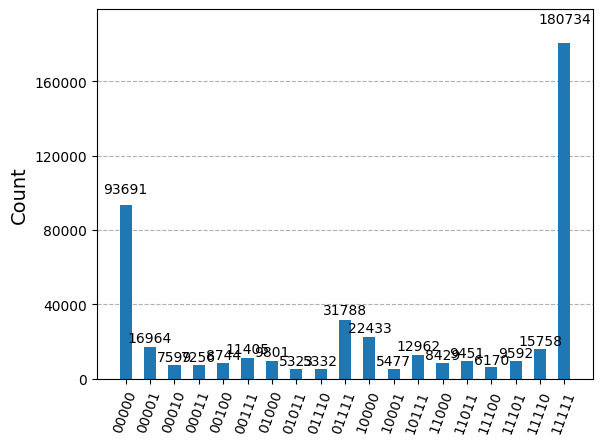

In [16]:
threshold = int(0.01 * n_shots)
filteredAnswer = {k: v for k,v in counts.items() if v >= threshold} 
removedCounts = np.sum([ v for k,v in counts.items() if v < threshold ]) 
plot_histogram(filteredAnswer)

### Using the encoding to take into account only the logical errors

In [17]:
counts_logical_1 = 0
for e in logical_1_codeword:
    counts_logical_1 += counts[e]
counts_logical_0 = 0
for e in logical_0_codeword:
    counts_logical_0 += counts[e]

if oracleType==1 and oracleValue ==1:
    print("Total fidelity F = ",counts_logical_1/(counts_logical_1+counts_logical_0)*100,"%")
else:
    print("Total fidelity F = ",counts_logical_0/(counts_logical_1+counts_logical_0)*100,"%")

Total fidelity F =  65.8591600619477 %


## Using custom backend

We propose a way to customize the noise of the FakeBackend in two ways:

1. Get the newest calibration noise from the real IBM quantum computers that are achieve through a csv file
2. Scale down this same noise by a scaling factor

In [ ]:
import json 
import pandas as pd
import os
from qiskit_ibm_runtime.fake_provider import fake_backend



def _load_json(filename: str) -> dict:
        with open(  # pylint: disable=unspecified-encoding
            os.path.join( filename)
        ) as f_json:
            the_json = json.load(f_json)
        return the_json


def update_computer_gate_noise(props_dict,new_dataset,gate_name_old,gate_name_new,scaling_factor):
    """
    Update and customize the noise model of the FakeKyiv computer backend.
    The noise can be updated using the noise calibration csv files that you can find 
    on the IBM quantum website.

    Warning: The scaling factor is not yet implemented

    Parameters
    ----------

    - props_dict [Dict]: the property dictionnary that describe the noise ratio of the 
                 custom Backend.
    - new_dataset [Dict]: the new dataset where you want to importe the noise
    - gate_name_old [string]: the gate that you want the noise value from the original dataset
    - gate_name_new [string]: the same gate name where you want to import the new noise
    - scaling factor [Float] : if you want to scale down or up the noise you can multiply the noise by
                      this factor  

    Returns
    -------
    - new_props_dict [Dict]: the updated props_dict with the new noise model

    """

    named_gates = [gate for gate in props_dict["gates"] if gate["gate"] == gate_name_old]
    #cleaning new dataset
    data_test  = list(new_dataset[gate_name_new].dropna())
    dictionary = {}

    # there are many ecr error value per lines of the dataset so one must be careful
    if gate_name_old == "ecr":
        for entry in data_test:
            pairs = entry.split(';')  
            for pair in pairs:
                key, value = pair.split(':')  
                key = list(map(int, key.split('_')))  
                dictionary[tuple(key)] = scaling_factor*float(value)

        # updating old dataset with new noise values
        for gate in named_gates:
            qubits = tuple(gate["qubits"])
            if qubits in dictionary:
                gate["parameters"][0]["value"] = dictionary[qubits]


    # single qubit case      
    else:
        for i,entry in enumerate(data_test):
            dictionary[i] = scaling_factor*(entry)
             
        for gate in named_gates:
            qubits = gate["qubits"][0]
            if qubits in dictionary:
                gate["parameters"][0]["value"] = dictionary[qubits]


    # Update props_dict elements with named_gates where the gate is gate_name_old
    for gate in props_dict["gates"]:
        if gate["gate"] == gate_name_old:
            matching_gate = next((named_gate for named_gate in named_gates if named_gate["qubits"] == gate["qubits"]), None)
            if matching_gate:
                gate.update(matching_gate)
    return props_dict




def update_computer_measurement_noise(old_dataset,new_dataset,scaling_factor):
    """
    Equivalent function for the measurement noise.
    Parameters
    ----------

    - old_datset:
    - old_datset:
    - scaling factor:

    Returns
    --------
    
    - Updated dataset
    """
    
    for i in range(len(old_dataset["qubits"])):
        old_dataset["qubits"][i][0]["value"] = new_dataset["T1 (us)"][i]
        old_dataset["qubits"][i][1]["value"] = new_dataset["T2 (us)"][i]
        old_dataset["qubits"][i][4]["value"] = scaling_factor*new_dataset["Readout assignment error "][i]
        old_dataset["qubits"][i][5]["value"] = scaling_factor*new_dataset["Prob meas0 prep1 "][i]
        old_dataset["qubits"][i][6]["value"] = scaling_factor*new_dataset["Prob meas1 prep0 "][i]
    return old_dataset


In [5]:
old_dataset = _load_json("/Users/yanislefur/Documents/encoded/experiments/repetition/Deutsh-Jozsa/config/props_kyiv_backup.json")  
print("Old gate noise example:",old_dataset["gates"])
print("Old measurement noise example:",old_dataset["qubits"][0][4])

Old gate noise example: [{'qubits': [0], 'gate': 'id', 'parameters': [{'date': '2024-02-28T02:04:14-05:00', 'name': 'gate_error', 'unit': '', 'value': 0.004492499696608774}, {'date': '2024-02-28T08:25:01-05:00', 'name': 'gate_length', 'unit': 'ns', 'value': 49.77777777777777}], 'name': 'id0'}, {'qubits': [1], 'gate': 'id', 'parameters': [{'date': '2024-02-28T02:14:30-05:00', 'name': 'gate_error', 'unit': '', 'value': 0.00012595193373459763}, {'date': '2024-02-28T08:25:01-05:00', 'name': 'gate_length', 'unit': 'ns', 'value': 49.77777777777777}], 'name': 'id1'}, {'qubits': [2], 'gate': 'id', 'parameters': [{'date': '2024-02-28T02:04:14-05:00', 'name': 'gate_error', 'unit': '', 'value': 0.00011464768728133887}, {'date': '2024-02-28T08:25:01-05:00', 'name': 'gate_length', 'unit': 'ns', 'value': 49.77777777777777}], 'name': 'id2'}, {'qubits': [3], 'gate': 'id', 'parameters': [{'date': '2024-02-28T02:14:30-05:00', 'name': 'gate_error', 'unit': '', 'value': 0.0001389385013952654}, {'date': '2

In [28]:


#importing datasets
old_dataset = _load_json("/Users/yanislefur/Documents/encoded/experiments/repetition/Deutsh-Jozsa/config/props_kyiv_backup.json")  # type: 
new_dataset = pd.read_csv("ibm_kyiv_calibrations_2025-02-26T16_02_56Z.csv")

old_keys = ["id","rz","sx","x","ecr"]
new_keys = ["ID error ","Z-axis rotation (rz) error ","√x (sx) error ","Pauli-X error ","ECR error "]

# updating noise
for i in range(len(old_keys)):
    update_computer_gate_noise(old_dataset,new_dataset,old_keys[i],new_keys[i],1.0)
    update_computer_measurement_noise(old_dataset,new_dataset,1.0)
with open("/Users/yanislefur/Documents/encoded/experiments/repetition/Deutsh-Jozsa/config/props_kyiv.json", "w") as f:
    json.dump(old_dataset, f)

print("New noise example:",old_dataset["gates"])
print("New noise example:",old_dataset["qubits"][0][4])

New noise example: [{'qubits': [0], 'gate': 'id', 'parameters': [{'date': '2024-02-28T02:04:14-05:00', 'name': 'gate_error', 'unit': '', 'value': 0.0001048485487606}, {'date': '2024-02-28T08:25:01-05:00', 'name': 'gate_length', 'unit': 'ns', 'value': 49.77777777777777}], 'name': 'id0'}, {'qubits': [1], 'gate': 'id', 'parameters': [{'date': '2024-02-28T02:14:30-05:00', 'name': 'gate_error', 'unit': '', 'value': 9.82890885453e-05}, {'date': '2024-02-28T08:25:01-05:00', 'name': 'gate_length', 'unit': 'ns', 'value': 49.77777777777777}], 'name': 'id1'}, {'qubits': [2], 'gate': 'id', 'parameters': [{'date': '2024-02-28T02:04:14-05:00', 'name': 'gate_error', 'unit': '', 'value': 0.0005987368452499}, {'date': '2024-02-28T08:25:01-05:00', 'name': 'gate_length', 'unit': 'ns', 'value': 49.77777777777777}], 'name': 'id2'}, {'qubits': [3], 'gate': 'id', 'parameters': [{'date': '2024-02-28T02:14:30-05:00', 'name': 'gate_error', 'unit': '', 'value': 0.000106993619251}, {'date': '2024-02-28T08:25:01-0

In [29]:
layout = {
    1 : [63, 64],
    3 : [65, 66, 67, 73, 84, 85],
    5 : [64, 65, 66, 67, 72,81, 82, 83, 84, 85],
    7 : [61, 62, 63, 64, 65, 66, 67, 72, 73, 81, 82, 83, 84, 85],
    #7 : [117,122,123, 124, 125, 126, 127,136,137,143,144,145,146,147]
}

In [30]:
class FakeKyiv2025(fake_backend.FakeBackendV2):
    """A fake 127 qubit backend configuration updated 2025."""

    dirname = os.path.dirname("/Users/yanislefur/Documents/encoded/experiments/repetition/Deutsh-Jozsa/config")  # 
    conf_filename = "/Users/yanislefur/Documents/encoded/experiments/repetition/Deutsh-Jozsa/config/conf_kyiv.json" 
    props_filename = "/Users/yanislefur/Documents/encoded/experiments/repetition/Deutsh-Jozsa/config/props_kyiv.json" 
    defs_filename = "/Users/yanislefur/Documents/encoded/experiments/repetition/Deutsh-Jozsa/config/defs_kyiv.json" 
    backend_name = "fake_kyiv2025" 


### Application on the analog DJ algorithm

0.991224


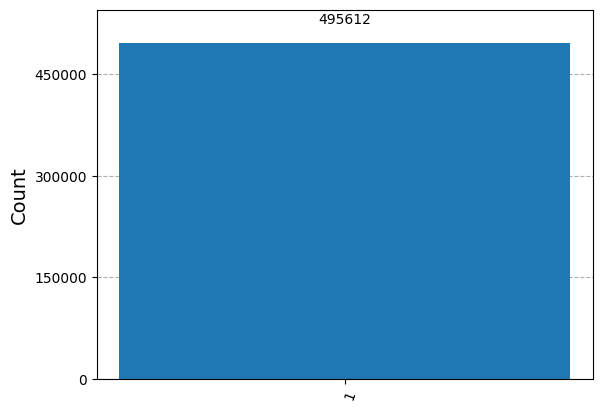

In [31]:
import qiskit_aer.noise as noise

n_shots = 500_000
qreg = cirq.LineQubit.range(total_qubits)
circuit = dj(qreg,oracleType,oracleValue)
circuit.append(cirq.measure(qreg[:total_qubits-1], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())
computer = FakeKyiv2025()

compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    initial_layout=layout[1],  
    routing_method="sabre",
    optimization_level=0,
)

job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()
threshold = int(0.01 * n_shots)
filteredAnswer = {k: v for k,v in counts.items() if v >= threshold} 
removedCounts = np.sum([ v for k,v in counts.items() if v < threshold ]) 
print((counts["1"]/n_shots))
plot_histogram(filteredAnswer)


## encoded

In [19]:
oracleType, oracleValue = 1, 2**(total_qubits-1)-1
k = 2 
n_encoding = 3

logical_1_codeword = ["1"*n_encoding*(k-1)]
logical_0_codeword = ["0"*n_encoding*(k-1)]

qreg = cirq.LineQubit.range(n_encoding*k)
circuit= dj_repetition(qreg,n_encoding,oracleType,oracleValue)
circuit= dj_repetition(qreg,n_encoding,oracleType,oracleValue)
print(circuit)
circuit.append(cirq.measure(qreg[:n_encoding*(k-1)], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())


compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    initial_layout=layout[n_encoding],
    routing_method="sabre", 
    optimization_level=3,
)
compiled_raw.count_ops()


                      ┌──┐
0: ───H───@───────@──────────────@───H───@───────
          │       │              │       │
1: ───────X───@───┼────@─────@───X───────X───@───
              │   │    │     │               │
2: ───────────X───┼────┼@────X───────────────X───
                  │    ││
3: ───X───H───@───X────┼┼────────────────────────
              │        ││
4: ───────────X───@────X┼────────────────────────
                  │     │
5: ───────────────X─────X────────────────────────
                      └──┘


OrderedDict([('rz', 98), ('sx', 59), ('ecr', 25), ('x', 4), ('measure', 3)])

In [20]:
job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()

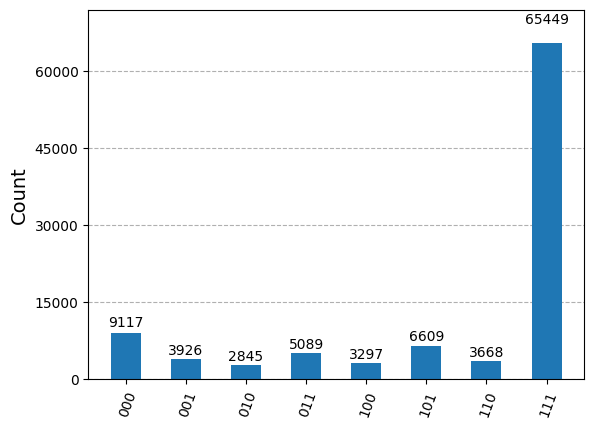

In [21]:
threshold = int(0.01 * n_shots)
filteredAnswer = {k: v for k,v in counts.items() if v >= threshold} 
removedCounts = np.sum([ v for k,v in counts.items() if v < threshold ]) 
plot_histogram(filteredAnswer)

In [22]:
counts_logical_1 = 0
for e in logical_1_codeword:
    counts_logical_1 += counts[e]
counts_logical_0 = 0
for e in logical_0_codeword:
    counts_logical_0 += counts[e]

if oracleType==1 and oracleValue ==1:
    print("Total fidelity F = ",counts_logical_1/(counts_logical_1+counts_logical_0)*100,"%")
else:
    print("Total fidelity F = ",counts_logical_0/(counts_logical_1+counts_logical_0)*100,"%")

Total fidelity F =  87.7732478609554 %


## Test repetition code in the X basis

In [49]:
circuit = cirq.Circuit()
qubits = cirq.LineQubit.range(6)
total_qubits = 6
circuit.append(cirq.H.on_each(*qubits))
circuit.append(cirq.CX(qubits[1],qubits[2]))
circuit.append(cirq.CX(qubits[0],qubits[1]))
circuit.append(cirq.H(qubits[0]))
circuit.append(cirq.CX(qubits[0],qubits[1]))
circuit.append(cirq.CX(qubits[1],qubits[2]))


circuit.append(cirq.CX(qubits[0],qubits[3]))
circuit.append(cirq.CX(qubits[1],qubits[4]))
circuit.append(cirq.CX(qubits[2],qubits[5]))

circuit.append(cirq.CX(qubits[1],qubits[2]))
circuit.append(cirq.CX(qubits[0],qubits[1]))
circuit.append(cirq.H(qubits[0]))
circuit.append(cirq.CX(qubits[0],qubits[1]))
circuit.append(cirq.CX(qubits[1],qubits[2]))
circuit.append(cirq.H.on_each(*qubits))
circuit.append(cirq.measure(qubits[:3], key="m"))
print(circuit)


simulator = stimcirq.StimSampler()
counts = simulator.run(circuit, repetitions=n_shots).histogram(key="m")

                          ┌──┐   ┌───┐
0: ───H───────@───H───@─────@────────────────@───H───@───H───────M('m')───
              │       │     │                │       │           │
1: ───H───@───X───────X────@┼─────@──────@───X───────X───@───H───M────────
          │                ││     │      │               │       │
2: ───H───X────────────────X┼─────┼@─────X───────────────X───H───M────────
                            │     ││
3: ───H─────────────────────X─────┼┼H─────────────────────────────────────
                                  ││
4: ───H───────────────────────────X┼─────H────────────────────────────────
                                   │
5: ───H────────────────────────────X─────H────────────────────────────────
                          └──┘   └───┘


In [50]:
counts

Counter({0: 500000})

In [63]:
from encoded.repetition_code import encoding_repetition, repetition_H, repetition_Z, repetition_CNOT
circuit_dj = cirq.Circuit()
qreg = cirq.LineQubit.range(6)
k = len(qreg) // n_encoding - 1
for i in range(k):
    repetition_H(circuit_dj, qreg, n_encoding, i)
circuit_dj


0: ───────@───H───@───────
          │       │
1: ───@───X───────X───@───
      │               │
2: ───X───────────────X───

In [ ]:
zerostate = np.array([1,0])
onestate = np.array([0,1])
pstate = (zerostate+onestate)/np.sqrt(2)
mstate = (zerostate-onestate)/np.sqrt(2)
pstate3 = np.kron(np.kron(pstate,pstate),pstate)
mstate3 = np.kron(np.kron(mstate,mstate),mstate)

circuit_H = cirq.Circuit()
qubits = cirq.LineQubit.range(3)

circuit_H.append(cirq.CX(qubits[2],qubits[1]))
circuit_H.append(cirq.CX(qubits[1],qubits[0]))
circuit_H.append(cirq.H(qubits[0]))
circuit_H.append(cirq.CX(qubits[1],qubits[0]))
circuit_H.append(cirq.CX(qubits[2],qubits[1]))
H3_gate  = cirq.unitary(circuit_H)

In [88]:
H3_gate@mstate3

array([-1.11855716e-17+0.j,  5.00000000e-01+0.j,  5.00000000e-01+0.j,
       -1.11855716e-17+0.j,  5.00000000e-01+0.j,  1.11855716e-17+0.j,
        1.11855716e-17+0.j,  5.00000000e-01+0.j])

In [89]:
(pstate3+mstate3)/np.sqrt(2)

array([0.5, 0. , 0. , 0.5, 0. , 0.5, 0.5, 0. ])